In [4]:
import pandas as pd
import re, nltk, gensim, spacy, scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from tqdm import tqdm
import analysis_toolbox as at

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\kpale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from pathlib import Path
platform = 'FOK!'
working_dir = Path('C:\\SHB\\',platform)
type = 'discussion_initiators'

In [6]:
users_df = pd.read_csv(working_dir.joinpath(platform + '_' + type +'_key_users.csv'))
df_comments = pd.read_csv(working_dir.joinpath(platform +'_comment_list.csv'),index_col='TopicID')
comments = df_comments[df_comments['Author_code'].isin(users_df['id'])]

<h2>Data Cleaning</h2>

In [7]:
threads = at.clean_comments(comments).groupby(['TopicID']).apply(lambda x: ' '.join(x))

In [8]:
# Define lemmatizer function
nlp = spacy.load("nl_core_news_sm")

# Lemmatization
tqdm.pandas()
threads = threads.progress_apply(lambda x: ' '.join([tok.lemma_ for tok in nlp(x)]))

100%|██████████| 1645/1645 [01:40<00:00, 16.31it/s]


In [9]:
# Define stopwords
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
dutch_stop_words = stopwords.words('dutch')
dutch_stop_words.extend(stopwords.words('english'))
dutch_stop_words.extend(['jij', 'jullie', 'wel', 'echt', 'alleen', 'jouw', 'af',\
                        'the', 'to', 'on', 'and', 'it', 'you'])
dutch_stop_words.remove('andere')
dutch_stop_words.remove('zelf')

def preprocess_topics(text):                           # Remove numbers, tags
    text = text.lower()
    text = re.sub(r'\[.*?\] ', '', text)
    text = re.sub(r'\d+', '', text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kpale\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Training LDA model and visualizing the results</h2>

In [10]:
# Scikit-learn implementation
def plot_top_words(model, n_topics, feature_names, n_top_words, title, n):
    fig, axes = plt.subplots(int(n_topics/n), n, figsize=(35, int(n_topics/n*7.5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.patch.set_facecolor('white')
    plt.show()

def implement_lda(data, n_topics, n_top_words, preprocessor=None, n_gram=1, plot=True):
    vec = CountVectorizer(ngram_range=(1, n_gram),
                      preprocessor=preprocessor,
                      stop_words=dutch_stop_words,
                      max_df=1.0, min_df=2)
    tf = vec.fit_transform(data)
    tf_feature_names = vec.get_feature_names_out()
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=666)
    # max_iter=5,learning_method='online',learning_offset=50.
    lda.fit(tf)
    if plot:
        plot_top_words(lda, n_topics, tf_feature_names, n_top_words, '', 4)
    return lda, tf_feature_names

def use_lda(data, n_topics, preprocessor=None, n_gram=1):
    vec = CountVectorizer(ngram_range=(1, n_gram),
                      preprocessor=preprocessor,
                      stop_words=dutch_stop_words,
                      max_df=0.95, min_df=2)
    tf = vec.fit_transform(data)
    tf_feature_names = vec.get_feature_names_out()
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=666)
    return lda.fit_transform(tf)

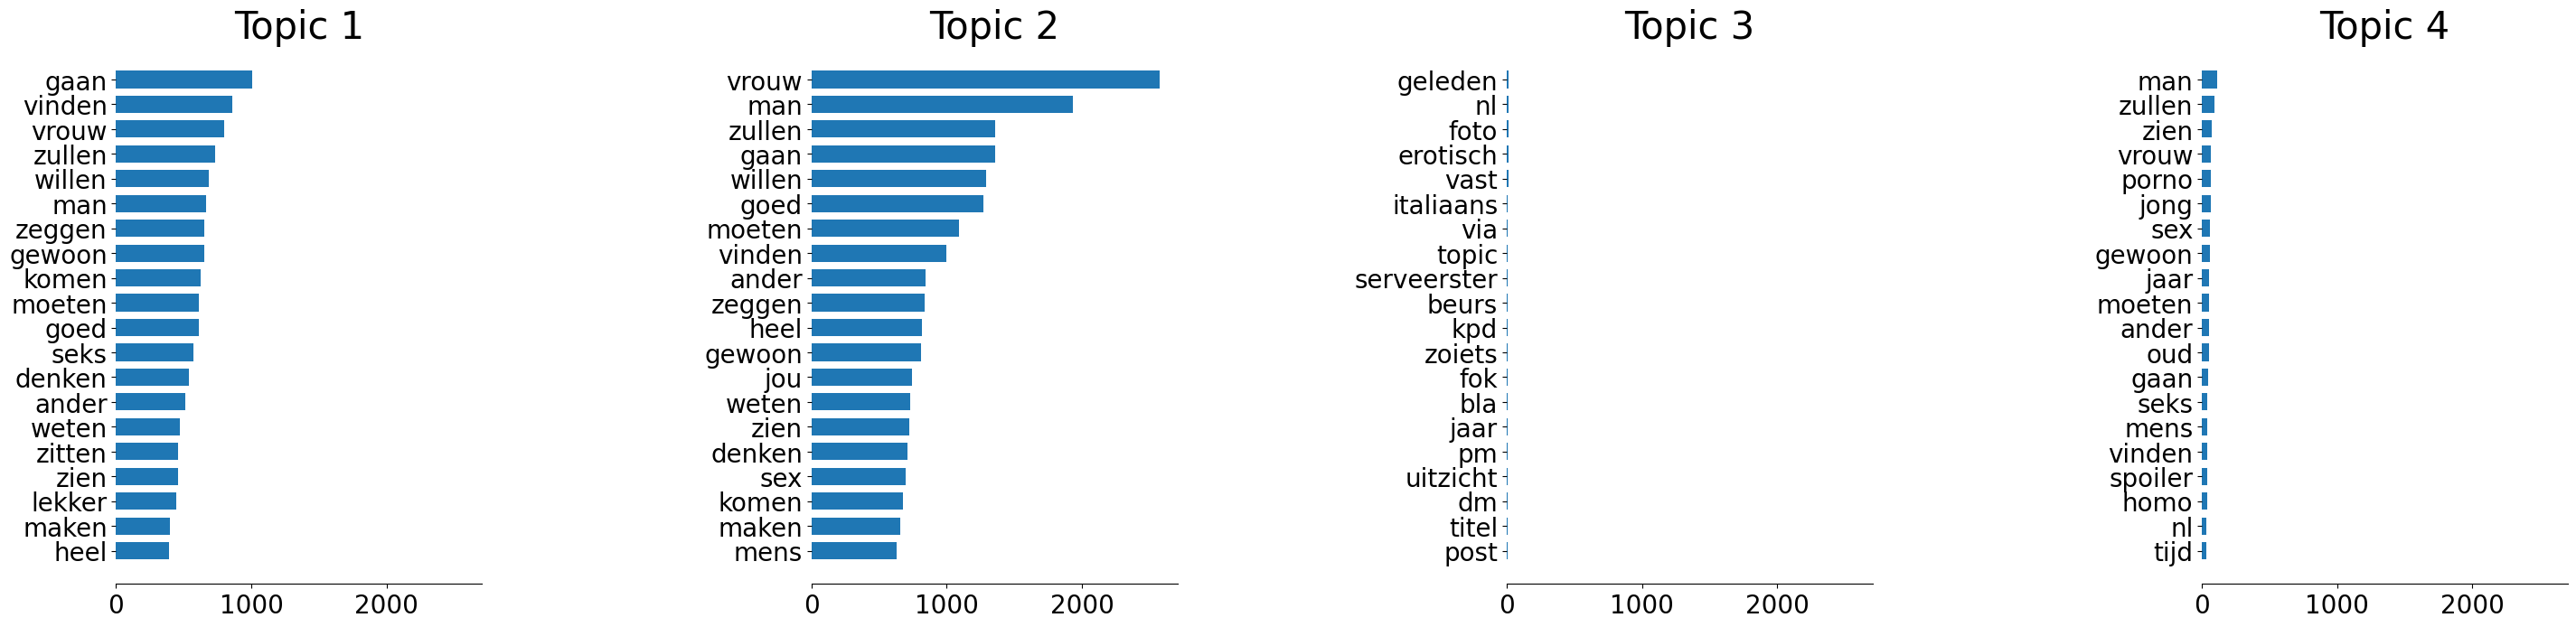

LatentDirichletAllocation(n_components=4, random_state=666)
Topic: 0
  gaan, vinden, vrouw, zullen, willen, man, zeggen, gewoon, komen, moeten, goed, seks, denken, ander, weten, zitten, zien, lekker, maken, heel
Topic: 1
  vrouw, man, zullen, gaan, willen, goed, moeten, vinden, ander, zeggen, heel, gewoon, jou, weten, zien, denken, sex, komen, maken, mens
Topic: 2
  geleden, nl, foto, erotisch, vast, italiaans, via, topic, serveerster, beurs, kpd, zoiets, fok, bla, jaar, pm, uitzicht, dm, titel, post
Topic: 3
  man, zullen, zien, vrouw, porno, jong, sex, gewoon, jaar, moeten, ander, oud, gaan, seks, mens, vinden, spoiler, homo, nl, tijd


In [11]:
N_TOPICS =4
lda, vocab = implement_lda(threads.loc[threads.str.len() > 100], N_TOPICS, 20, preprocess_topics, n_gram=1)
#output = use_lda(threads.loc[threads.str.len() > 100], N_TOPICS, preprocess_topics, n_gram=1)
#top_threads_by_topic = [None] + [np.array(pd.DataFrame(output).sort_values(by=i, ascending=False)[:30].index) for i in range(N_TOPICS)]
print(lda)
for topic, comp in enumerate(lda.components_):   
    word_idx = np.argsort(comp)[::-1][:20]
    print('Topic: %d' % topic)
    # store the words most relevant to the topic
    print('  %s' % ', '.join([vocab[i] for i in word_idx]))

<h2>Hyperparameter tuning on the number of topics</h2>

In [12]:
def find_optimal_ntopics(ntopic_range, coherence='c_v'):
    vec = CountVectorizer(ngram_range=(1, 1),
                          preprocessor=preprocess_topics,
                          stop_words=dutch_stop_words,
                          max_df=1.0, min_df=2)
    tf = vec.fit_transform(threads.loc[threads.str.len() > 100])
    
    corpus = gensim.matutils.Sparse2Corpus(tf, documents_columns=False)
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    d = gensim.corpora.Dictionary()
    d.id2token = dict((v, k) for k, v in vec.vocabulary_.items())
    d.token2id = dict((k, v) for k, v in vec.vocabulary_.items())
    texts = vec.inverse_transform(tf)
    
    history = dict()
    
    for i in ntopic_range:
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, id2word=id2word, offset=10.0, decay=0.7, chunksize=128,
                                                            passes=10, num_topics=i, random_state=666, batch=True)
        coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus,
                                                           texts=texts, dictionary=d, coherence=coherence)
        history[i] = coherence_model_lda.get_coherence()
        
    return history

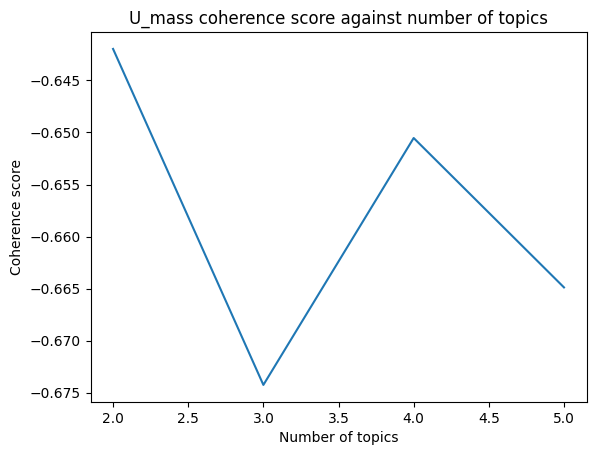

In [13]:
rng = range(2, 6, 1)
plt.plot(rng, list(find_optimal_ntopics(rng, 'u_mass').values()), '-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('U_mass coherence score against number of topics')
plt.show()

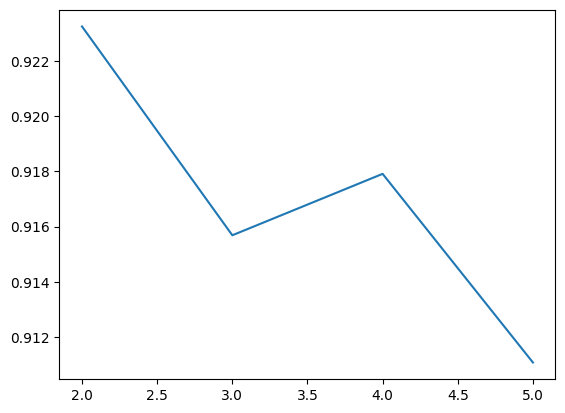

In [14]:
plt.plot(rng, list(find_optimal_ntopics(rng).values()), '-')
plt.show()

In [15]:
print(find_optimal_ntopics([4],'u_mass'))

{4: -0.6505319253142765}


<h2>Create final LDA model</h2>

In [16]:
output = use_lda(threads.loc[threads.str.len() > 100], 16, preprocess_topics, n_gram=1)
top_threads_by_topic = [None] + [np.array(pd.DataFrame(output).sort_values(by=i, ascending=False)[:30].index) for i in range(16)]

<h2>Write an Excel file with top 30 threads from each topic and all their comments</h2>

In [17]:
with pd.ExcelWriter("Fok_16topics_top30threads.xlsx", engine='openpyxl') as writer:
    # For each topic
    for topic_no in range(1, 17):
        # Get topic IDs of top 30 threads
        topic_IDs = threads.loc[threads.str.len() > 100].iloc[top_threads_by_topic[topic_no]].index
        # Get the comments in the top 30 threads
        df = comments[comments.TopicID.isin(topic_IDs)].dropna()
        df["Comment"] = df["Comment"].astype(str)
        # Add a column of relevance ranking
        df = df.merge(topics[topics.ID.isin(topic_IDs)].set_index("ID").loc[topic_IDs]\
                      .reset_index(drop=False).loc[:, ['TopicID', 'Title']].reset_index(level=0), 
                      on='TopicID').rename(columns={"index": "rank"})
        df['rank'] = df['rank'] + 1
        df = df.loc[:, ['rank', 'TopicID', 'CommentID', 'Comment', 'Time']]
        df = df.sort_values(by=['rank', 'CommentID'])
        df.to_excel(writer, sheet_name="Topic"+str(topic_no), index=False)
        
        df2 = topics[topics.ID.isin(topic_IDs)].set_index("ID").loc[topic_IDs].loc[:, ['Title', 'URL']].reset_index(drop=False)\
        .reset_index(level=0).rename(columns={"index": "rank"})
        df2['rank'] = df2['rank'] + 1
        df2.to_excel(writer, sheet_name="Topic"+str(topic_no)+" URLs", index=False)

IndexError: At least one sheet must be visible

<h2>Write an Excel file with all related threads from 5 selected topics and all their comments</h2>

In [ ]:
# Get all relevant threads for Topics 2, 7, 10, 11 & 15
top_threads_by_topic_full = [None] + [np.array(pd.DataFrame(output).sort_values(by=i, ascending=False).index) for i in range(16)]

In [ ]:
relevance_threshold = 1/16

with pd.ExcelWriter("Fok_5selectedtopics.xlsx", engine='openpyxl') as writer:
    for topic_no in (2, 7, 10, 11, 15):
        # Calculate relevance scores of all threads in respect to the given topic
        relevance_scores = output[top_threads_by_topic_full[topic_no], topic_no-1]
        # Filter threads that exceed relevance score threshold
        topic_IDs = threads.loc[threads.str.len() > 100]\
        .iloc[top_threads_by_topic_full[topic_no][relevance_scores > relevance_threshold]].index
        df = comments[comments.TopicID.isin(topic_IDs)].dropna()
        df["Comment"] = df["Comment"].astype(str)
        df = df.merge(topics[topics.ID.isin(topic_IDs)].set_index("ID").loc[topic_IDs]\
                      .reset_index(drop=False).loc[:, ['TopicID', 'Title']].reset_index(level=0), 
                      on='TopicID').rename(columns={"index": "rank"})
        df['rank'] = df['rank'] + 1
        df = df.loc[:, ['rank', 'TopicID', 'CommentID', 'Comment', 'Time']]
        df = df.sort_values(by=['rank', 'CommentID'])
        # Filter comments that were posted before 2016 (5 years from the time of scraping)
        df = df[df['Time'].str.contains("2016|2017|2018|2019|2020|2021")]
        df.to_excel(writer, sheet_name="Topic"+str(topic_no), index=False)
        
        df2 = topics[topics.ID.isin(topic_IDs)].set_index("ID").loc[topic_IDs].loc[:, ['Title', 'URL']].reset_index(drop=False)\
        .reset_index(level=0).rename(columns={"index": "rank"})
        df2['rank'] = df2['rank'] + 1
        df2.insert(1, 'relevance_score', relevance_scores[relevance_scores > relevance_threshold])
        df2.to_excel(writer, sheet_name="Topic"+str(topic_no)+" URLs", index=False)

In [ ]:
for topic_no in (2, 7, 10, 11, 15):
    relevance_scores = output[top_threads_by_topic_full[topic_no], topic_no-1]
    print(sum(relevance_scores > 0.0625))